#2) 양방향 LSTM을 이용한 품사 태깅
## 1. 품사 태깅 데이터에 대한 이해와 전처리

In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
import nltk
nltk.download('treebank')

# 토큰화에 품사 태깅이 된 데이터 받아오기
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print("품사 태깅이 된 문장 개수 :", len(tagged_sentences))

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
품사 태깅이 된 문장 개수 : 3914


In [4]:
print(tagged_sentences[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [5]:
sentences, pos_tags = [], []
for tagged_sentence in tagged_sentences:   # 3,914개의 문장 샘플을 1개씩 불러온다
  sentence, tag_info = zip(*tagged_sentence)    # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장한다
  sentences.append(list(sentence))    # 각 샘픙레서 단어 정보만 저장한다
  pos_tags.append(list(tag_info))    # 각 샘플에서 품사 태깅 정보만 저장한다

In [6]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


In [7]:
print(sentences[8])
print(pos_tags[8])

['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


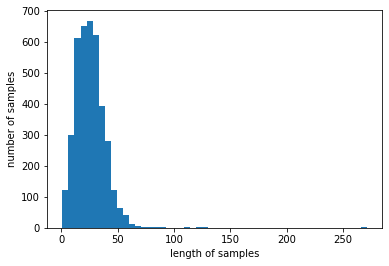

In [8]:
print("샘플의 최대 길이 : %d" % max(len(l) for l in sentences))
print("샘플의 평균 길이 : %f" % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
# 케라스 토크나이저 함수로 구현
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

In [10]:
# 문장에 대해서는 src_tokenizer를, 레이블에 해당되는 품사 태깅 정보에 대해서는 tag_tokenizer를 사용
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

In [11]:
# 단어 집합과 품사 태깅 정보 집합의 크기 확인
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print("단어 집합의 크기 : {}".format(vocab_size))
print("태깅 정보 집합의 크기 : {}".format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [12]:
# 문장 데이터에 대해서 정수 인코딩이 수행된 결과
x_train = src_tokenizer.texts_to_sequences(sentences)
# 품사 태깅 데이터에 대해서 정수 인코딩이 수행된 결과
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [13]:
print(x_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [14]:
max_len = 150
x_train = pad_sequences(x_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=.2, random_state=777)

In [18]:
print('훈련 샘플 문장의 크기 : {}'.format(x_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(x_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150)


## 2. 양방향 LSTM으로 POS Tagger 만들기

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=7, validation_data=(x_test, y_test))

Epoch 1/7
25/25 [==============================] - 68s 2s/step - loss: 0.5939 - accuracy: 0.1524 - val_loss: 0.5163 - val_accuracy: 0.1611
Epoch 2/7
25/25 [==============================] - 51s 2s/step - loss: 0.5021 - accuracy: 0.1985 - val_loss: 0.4786 - val_accuracy: 0.2815
Epoch 3/7
25/25 [==============================] - 47s 2s/step - loss: 0.4494 - accuracy: 0.3751 - val_loss: 0.3962 - val_accuracy: 0.4671
Epoch 4/7
25/25 [==============================] - 48s 2s/step - loss: 0.3312 - accuracy: 0.5217 - val_loss: 0.2595 - val_accuracy: 0.6162
Epoch 5/7
25/25 [==============================] - 49s 2s/step - loss: 0.2029 - accuracy: 0.7193 - val_loss: 0.1534 - val_accuracy: 0.8010
Epoch 6/7
25/25 [==============================] - 48s 2s/step - loss: 0.1120 - accuracy: 0.8705 - val_loss: 0.0941 - val_accuracy: 0.8807
Epoch 7/7
25/25 [==============================] - 48s 2s/step - loss: 0.0643 - accuracy: 0.9277 - val_loss: 0.0675 - val_accuracy: 0.9058


In [20]:
print("\n 테스트 정확도 : %.4f" %(model.evaluate(x_test, y_test)[1]))

25/25 [==============================] - 4s 153ms/step - loss: 0.0675 - accuracy: 0.9058

 테스트 정확도 : 0.9058


In [21]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

i = 10    # 확인하고 싶은 테스트용 샘플의 인덱스
y_predicted = model.predict(np.array([x_test[i]]))    # 입력한 테스트용 샘플에 대해서 예측값 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1)    # 확률 벡터를 정수 레이블로 변환

print("{:15}|{:5}|{}".format("단어","실제값","예측값"))
print(35 * "-")

for word, tag, pred in zip(x_test[i], y_test[i], y_predicted[0]):
  if word != 0:    # PAD값은 제외함
    print("{:17} : {:7} {}". format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in                : IN      IN
addition          : NN      NN
,                 : ,       ,
buick             : NNP     NNP
is                : VBZ     VBZ
a                 : DT      DT
relatively        : RB      RB
respected         : VBN     JJ
nameplate         : NN      NN
among             : IN      IN
american          : NNP     NNP
express           : NNP     NNP
card              : NN      NN
holders           : NNS     NNS
,                 : ,       ,
says              : VBZ     VBZ
0                 : -NONE-  -NONE-
*t*-1             : -NONE-  -NONE-
an                : DT      DT
american          : NNP     NNP
express           : NNP     NNP
spokeswoman       : NN      NN
.                 : .       .


# 3) 개체명 인식
## 2. NLTK를 이용한 개체명 인식

In [24]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk import word_tokenize, pos_tag, ne_chunk

sentence = "James is working at Disney in London"
# 토큰화 후 품사 태깅
tokenized_sentence = pos_tag(word_tokenize(sentence))
print(tokenized_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [27]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

# 개체명 인식
ner_sentence = ne_chunk(tokenized_sentence)
print(ner_sentence)

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


# 4) 개체명 인식의 BIO 표현 이해하기
## 3. 데이터 전처리하기

In [28]:
import re
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [30]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")

f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
  if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == '\n':
    if len(sentence) > 0:
      tagged_sentences.append(sentence)
      sentence = []
    continue
  splits = line.split(' ')    # 공백을 기준으로 속성을 구분한다
  splits[-1] = re.sub(r'\n', '', splits[-1])    # 줄바꿈 표시 \n을 제거한다
  word = splits[0].lower()    # 단어들은 소문자로 바꿔서 저장한다
  sentence.append([word, splits[-1]])    # 단어와 개체명 태깅만 기록한다

In [31]:
print("전체 샘플 개수 :", len(tagged_sentences))

전체 샘플 개수 : 14041


In [32]:
print("첫번째 샘플 :", tagged_sentences[0])

첫번째 샘플 : [['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [33]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:    # 14,041개의 문장 샘플을 1개씩 불러온다
  sentence, tag_info = zip(*tagged_sentence)    # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장
  sentences.append(list(sentence))    # 각 샘플에서 단어 정보만 저장한다
  ner_tags.append(list(tag_info))    # 각 샘플에서 개체명 태깅 정보만 저장한다

In [34]:
print("첫번째 샘플의 문장 :", sentences[0])
print("첫번째 샘플의 레이블 :", ner_tags[0])

첫번째 샘플의 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
첫번째 샘플의 레이블 : ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [35]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


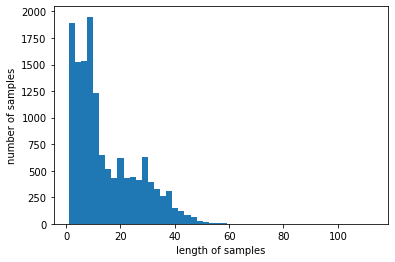

In [36]:
print("샘플의 최대 길이 : %d" % max(len(sentence) for sentence in sentences))
print("샘플의 평균 길이 : %f" % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [37]:
vocab_size = 4000
src_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [38]:
tag_size = len(tar_tokenizer.word_index) + 1
print("단어 집합의 크기 : {}".format(vocab_size))
print("개체명 태깅 정보 집합의 크기 : {}".format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


In [39]:
x_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [40]:
print("첫번째 샘플의 문장 :", x_train[0])
print("첫번째 샘플의 레이블 :", y_train[0])

첫번째 샘플의 문장 : [989, 1, 205, 629, 7, 3939, 216, 1, 3]
첫번째 샘플의 레이블 : [4, 1, 7, 1, 1, 1, 7, 1, 1]


In [41]:
# 디코딩 작업을 위해 정수로부터 단어로 변환하는 index_to_word 작성
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [42]:
# 정수 인코딩 된 첫번째 문장을 디코딩
decoded = []
for index in x_train[0]:    # 첫번째 샘플 안의 각 정수로 변환된 단어에 대해서
  decoded.append(index_to_word[index])    # 단어로 변환

print("기존 문장 : {}".format(sentences[0]))
print("빈도수가 낮은 단어가 oov 처리된 문장 : {}".format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 oov 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [43]:
# 패딩
max_len = 70
x_train = pad_sequences(x_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=.2, random_state=777)

In [45]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [47]:
print('훈련 샘플 문장의 크기 : {}'.format(x_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(x_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


## 4. 양방향 LSTM으로 개체명 인식기 만들기

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=8, validation_data=(x_test, y_test))

Epoch 1/8
88/88 [==============================] - 102s 990ms/step - loss: 0.2014 - accuracy: 0.8229 - val_loss: 0.1336 - val_accuracy: 0.8335
Epoch 2/8
88/88 [==============================] - 78s 883ms/step - loss: 0.1082 - accuracy: 0.8460 - val_loss: 0.0848 - val_accuracy: 0.8739
Epoch 3/8
88/88 [==============================] - 79s 895ms/step - loss: 0.0744 - accuracy: 0.8919 - val_loss: 0.0599 - val_accuracy: 0.9140
Epoch 4/8
88/88 [==============================] - 77s 876ms/step - loss: 0.0531 - accuracy: 0.9248 - val_loss: 0.0452 - val_accuracy: 0.9363
Epoch 5/8
88/88 [==============================] - 79s 900ms/step - loss: 0.0398 - accuracy: 0.9436 - val_loss: 0.0377 - val_accuracy: 0.9472
Epoch 6/8
88/88 [==============================] - 79s 903ms/step - loss: 0.0321 - accuracy: 0.9545 - val_loss: 0.0342 - val_accuracy: 0.9522
Epoch 7/8
88/88 [==============================] - 79s 895ms/step - loss: 0.0276 - accuracy: 0.9604 - val_loss: 0.0325 - val_accuracy: 0.9535
Epoch

In [51]:
print("\n 테스트 정확도 : %.4f"%(model.evaluate(x_test, y_test)[1]))

88/88 [==============================] - 7s 77ms/step - loss: 0.0324 - accuracy: 0.9536

 테스트 정확도 : 0.9536


In [53]:
i = 10    # 확인하고 싶은 테스트용 샘플의 인덱스

# 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = model.predict(np.array([x_test[i]]))

# 확률 벡터를 정수 레이블로 변경
y_predicted = np.argmax(y_predicted, axis=-1)

# 원-핫 벡터를 정수 인코딩으로 변경
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(x_test[i], labels, y_predicted[0]):
  if word != 0:    # PAD값은 제외함
    print("{:17} : {:7} {}".format(index_to_word[word], index_to_ner[tag].upper(), index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
sarah             : B-PER   B-PER
brady             : I-PER   I-PER
,                 : O       O
whose             : O       O
republican        : B-MISC  B-MISC
husband           : O       O
was               : O       O
OOV               : O       O
OOV               : O       O
in                : O       O
an                : O       O
OOV               : O       O
attempt           : O       O
on                : O       O
president         : O       O
ronald            : B-PER   B-PER
reagan            : I-PER   I-PER
,                 : O       O
took              : O       O
centre            : O       O
stage             : O       O
at                : O       O
the               : O       O
democratic        : B-MISC  B-MISC
national          : I-MISC  I-MISC
convention        : I-MISC  I-MISC
on                : O       O
monday            : O       O
night             : O       O
to                : O       O
OO

# 5) BiLSTM을 이용한 개체명 인식
## 1. 개체명 인식 데이터에 대한 이해와 전처리

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [55]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20Sequence%20Labeling/dataset/ner_dataset.csv", filename="ner_dataset.csv")
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [56]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [57]:
print("데이터 프레임 행의 개수 : {}".format(len(data)))

데이터 프레임 행의 개수 : 1048575


In [58]:
print("데이터에 Null값이 있는지 유무 : " + str(data.isnull().values.any()))

데이터에 Null값이 있는지 유무 : True


In [59]:
print("어떤 열에 Null값이 잇는지 출력")
print("==============================")
data.isnull().sum()

어떤 열에 Null값이 잇는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [60]:
# nunique() : 전체 데이터에서 중복을 허용하지 않고 유일한 값의 개수를 세주는 함수
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [62]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [63]:
data = data.fillna(method='ffill')
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [64]:
print("데이터에 Null 값이 있는지 유무 : " + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


In [65]:
# 모든 단어 소문자화
data['Word'] = data['Word'].str.lower()
print("Word 열의 중복을 제거한 값의 개수 : {}".format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [66]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


In [67]:
# 하나의 문장에 등장한 단어와 개체명 태깅 정보끼리 쌍으로 묶는 작업
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences = [t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수 : {}".format(len(tagged_sentences)))

전체 샘플 개수 : 47959


In [68]:
print(tagged_sentences[0])    # 첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [70]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:    # 47,959개의 문장 샘플을 1개씩 불러온다
  # 각 샘플에서 단어들은 sentence에, 개체명 태깅 정보들은 tag_info에 저장
  sentence, tag_info = zip(*tagged_sentence)
  sentences.append(list(sentence))    # 각 샘플에서 단어 정보만 저장한다
  ner_tags.append(list(tag_info))    # 각 샘플에서 개체명 태깅 정보만 저장한다

In [71]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [72]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


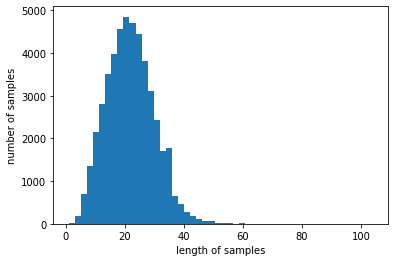

In [73]:
print("샘플의 최대 길이 : %d" % max(len(l) for l in sentences))
print("샘플의 평균 길이 : %f" % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [74]:
# 케라스 토크나이저를 이요한 정수 인코딩

# 모든 단어를 사용하며 인덱스 1에는 단어 'oov'를 할당
src_tokenizer = Tokenizer(oov_token='OOV')
# 태깅 정보들은 내부적으로 대문자를 유지한 채 저장
tar_tokenizer = Tokenizer(lower=False)

src_tokenizer.fit_on_texts(sentences)
tar_tokenizer.fit_on_texts(ner_tags)

In [75]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print("단어 집합의 크기 : {}".format(vocab_size))
print("개체명 태깅 정보 집합의 크기 : {}".format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [76]:
# 인덱스 1에 OOV 할당
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [77]:
x_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [78]:
print(x_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [79]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [80]:
# index_to_word를 통해 첫번째 샘플의 정수 시퀀스를 텍스트 시퀀스로 변환하는 디코딩 작업
decoded = []
for index in x_data[0]:    # 첫번째 샘플 안의 인덱스들에 대해서
  decoded.append(index_to_word[index])    # 다시 단어로 변환

print("기존의 문장 : {}".format(sentences[0]))
print("디코딩 문장 : {}".format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [81]:
# 패딩
max_len = 70
x_data = pad_sequences(x_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [82]:
x_train, x_test, y_train_int, y_test_int = train_test_split(x_data, y_data, test_size=.2, random_state=777)

In [84]:
# 레이블에 해당하는 태깅 정보에 대해 원-핫 인코딩 수행
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [86]:
print('훈련 샘플 문장의 크기 : {}'.format(x_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(x_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (38367, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (9592, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (9592, 70, 18)


## 2. 양방향 LSTM을 이용한 개체명 인식

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=6, validation_split=0.1)

Epoch 1/6
270/270 [==============================] - 545s 2s/step - loss: 0.1738 - accuracy: 0.8762 - val_loss: 0.0777 - val_accuracy: 0.9301
Epoch 2/6
270/270 [==============================] - 524s 2s/step - loss: 0.0539 - accuracy: 0.9505 - val_loss: 0.0490 - val_accuracy: 0.9540
Epoch 3/6
270/270 [==============================] - 525s 2s/step - loss: 0.0364 - accuracy: 0.9649 - val_loss: 0.0456 - val_accuracy: 0.9568
Epoch 4/6
270/270 [==============================] - 377s 1s/step - loss: 0.0295 - accuracy: 0.9707 - val_loss: 0.0439 - val_accuracy: 0.9584
Epoch 5/6
270/270 [==============================] - 350s 1s/step - loss: 0.0254 - accuracy: 0.9743 - val_loss: 0.0430 - val_accuracy: 0.9592
Epoch 6/6
270/270 [==============================] - 346s 1s/step - loss: 0.0223 - accuracy: 0.9770 - val_loss: 0.0449 - val_accuracy: 0.9589


In [89]:
# 13번 샘플에 대해서 실제값과 예측값 비교
i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([x_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 인코딩으로 변경함.
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(x_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


## 3. F1-score

In [90]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['O'] * len(labels) 
print('예측값 :',predicted)

예측값 : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [91]:
hit = 0    # 정답 개수
for tag, pred in zip(labels, predicted):
  if tag == pred:
    hit += 1    # 정답인 경우에만 + 1
accuracy = hit/len(labels)    # 정답 개수를 총 개수로 나눈다
print("정확도 : {:.1%}".format(accuracy))

정확도 : 74.4%


In [92]:
pip install seqeval

     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=3e890352e83ef236a8d03ed7bd1c8f9e6d81517300d6f2f63bed8e57cf89f2c9
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [93]:
from seqeval.metrics import classification_report
print(classification_report([labels], [predicted]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
labels = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O']

print(classification_report([labels], [predicted]))

              precision    recall  f1-score   support

        MISC       1.00      0.50      0.67         2
         PER       1.00      0.67      0.80         3

   micro avg       1.00      0.60      0.75         5
   macro avg       1.00      0.58      0.73         5
weighted avg       1.00      0.60      0.75         5



## 4. F1-score로 성능 측정하기

In [97]:
from seqeval.metrics import f1_score, classification_report

def sequences_to_tag(sequences):
  result = []
  # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다
  for sequence in sequences:
    word_sequence = []
    # 시퀀스로부터 확률 벡터 또는 원-핫 벡터를 하나씩 꺼낸다
    for pred in sequence:
      # 정수로 변환. 예를 들어 pred가 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다
      pred_index = np.argmax(pred)
      # index_to_ner을 사용하여 정수를 태깅 정보로 변환, 'PAD'는 'O'로 변경
      word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
    result.append(word_sequence)
  return result

y_predicted = model.predict([x_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score : {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))

F1-score : 78.4%
              precision    recall  f1-score   support

         art       0.08      0.02      0.03        63
         eve       0.58      0.27      0.37        52
         geo       0.80      0.87      0.83      7620
         gpe       0.96      0.94      0.95      3145
         nat       0.38      0.27      0.32        37
         org       0.62      0.53      0.57      4033
         per       0.72      0.71      0.71      3545
         tim       0.85      0.83      0.84      4067

   micro avg       0.79      0.78      0.78     22562
   macro avg       0.62      0.55      0.58     22562
weighted avg       0.78      0.78      0.78     22562

